# Intersection over Union (IoU)

Intersection over Union (IoU) is also known as Jaccard Index, have a look at Wikipedia for a great explanation - [Wikipedia](https://en.wikipedia.org/wiki/Jaccard_index)

In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_cv

In [31]:
# Define the bounding boxes
box1 = np.array([50, 50, 100, 100])  # [x1, y1, x2, y2]
box2 = np.array([75, 75, 150, 150])  # [x1, y1, x2, y2]

In [32]:
# Calculate the intersection and union
x1 = max(box1[0], box2[0])
y1 = max(box1[1], box2[1])
x2 = min(box1[2], box2[2])
y2 = min(box1[3], box2[3])
intersection = max(0, x2 - x1) * max(0, y2 - y1)
area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
union = area1 + area2 - intersection

In [33]:
# Calculate the IoU
iou = intersection / union

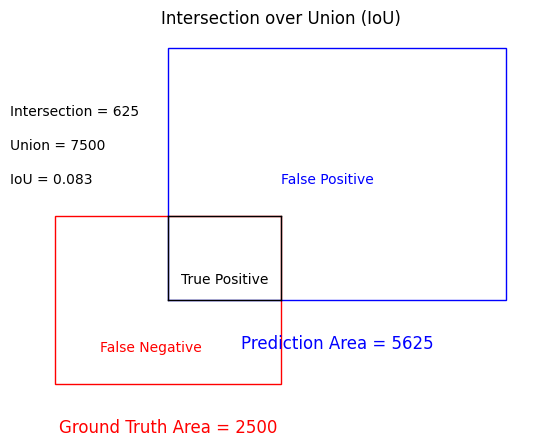

In [34]:
# Plot the bounding boxes and intersection/union
fig, ax = plt.subplots()
rect1 = plt.Rectangle((box1[0], box1[1]), box1[2] - box1[0], box1[3] - box1[1], linewidth=1, edgecolor='r', facecolor='none')
rect2 = plt.Rectangle((box2[0], box2[1]), box2[2] - box2[0], box2[3] - box2[1], linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.title('Intersection over Union (IoU)')
plt.plot([x1, x2], [y1, y1], linewidth=1, color='k')
plt.plot([x1, x2], [y2, y2], linewidth=1, color='k')
plt.plot([x1, x1], [y1, y2], linewidth=1, color='k')
plt.plot([x2, x2], [y1, y2], linewidth=1, color='k')
plt.text(0.5 * (box1[0] + box1[2]), box1[1] - 10, 'Ground Truth Area = %d' % area1, horizontalalignment='center', verticalalignment='top', fontsize=12, color='r')
plt.text(0.5 * (box2[0] + box2[2]), box2[1] - 10, 'Prediction Area = %d' % area2, horizontalalignment='center', verticalalignment='top', fontsize=12, color='b')
plt.text(40, 130, f'Intersection = {intersection}', fontsize=10, color='k')
plt.text(40, 120, f'Union = {union}', fontsize=10, color='k')
plt.text(40, 110, f'IoU = {iou:.3f}', fontsize=10, color='k')
plt.text(100, 110, f'False Positive', fontsize=10, color='b')
plt.text(60, 60, f'False Negative', fontsize=10, color='r')
plt.text(78, 80, f'True Positive', fontsize=10, color='k')
plt.axis('off')
plt.show()

### Implementation with Keras

#### Detection (bounding boxes) input

To calculate the IoU for bounding boxes, with the coordinate of the edges, kerascv [compute_iou](https://keras.io/api/keras_cv/bounding_box/utils/compute_iou/) will do.

In [35]:
# wrap box1 in axis 0 to make it a batch of size 1
box1 = np.expand_dims(box1, axis=0)
box1

array([[ 50,  50, 100, 100]])

In [36]:
# wrap box1 in axis 0 to make it a batch of size 1
box2 = np.expand_dims(box2, axis=0)
box2

array([[ 75,  75, 150, 150]])

In [41]:
keras_cv.bounding_box.compute_iou( boxes1=box1, boxes2=box2, bounding_box_format='xyxy').numpy()

array([[0.08333334]], dtype=float32)

#### Segmentation (pixels) Input

Note that in Keras `IoU`, `BinaryIoU` and `meanIoU` have a different input than the bounding box edges - that is the prediction per pixel.
In Keras:
* `BinaryIoU` calculates the IoU over a single binary class ([docs](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryIoU))
* `IoU` calculates IoU over a single class ([docs](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/IoU))
* `meanIoU` calculates the mean IoU over multiple classes ([docs](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU))

The formula for all of these three is:
```
iou = true_positives / (true_positives + false_positives + false_negatives)
```

For example, assume you are trying to predict if each pixel is cat, dog, or background. 
You have 80% background pixels, 10% dog, and 10% cat.
The model predicts 100% background.

#### IoU

In [38]:
m = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])
m.update_state([0, 0, 1, 1], [0, 1, 0, 1])
m.result().numpy()

0.33333334

Let's analyze:

|Ground Truth|Prediction|Outcome|
|------------|----------|-------|
|0|0|True Positive|
|0|1|False Negative|
|1|0|False Positive|
|1|1|True Negative|

So according to the formula:

```
iou = 1/(1+1+1) = 0.33
```

#### Binary IoU

In [39]:
m = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3)
m.update_state([0, 1, 0, 1], [0.1, 0.2, 0.4, 0.7])
m.result().numpy()

0.33333334

**To the Student**: To understand why the calculation is over both labels, see the docs of `BinaryIoU` for `target_class_ids`.

Let's analyze:

|Ground Truth|Prediction|Outcome with respect to label 0|Output with respect to label 1|
|------------|----------|-------------------------------|------------------------------|
|0|0.1<0.3 => 0|True Positive|True Negative|
|1|0.2<0.3 => 0|False Positive|False Negative|
|0|0.4>0.3 => 1|False Negative|False Positive|
|1|0.7>0.3 => 1|True Negative|True Positive|

So according to the formula:

```
iou = 1/(1+1+1) + 1/(1+1+1)= (0.33 + 0.33)/2 = 0.33
```

#### MeanIoU

In [40]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state([0, 0, 1, 1], [0, 1, 0, 1])
m.result().numpy()


0.33333334